---
- 07/23

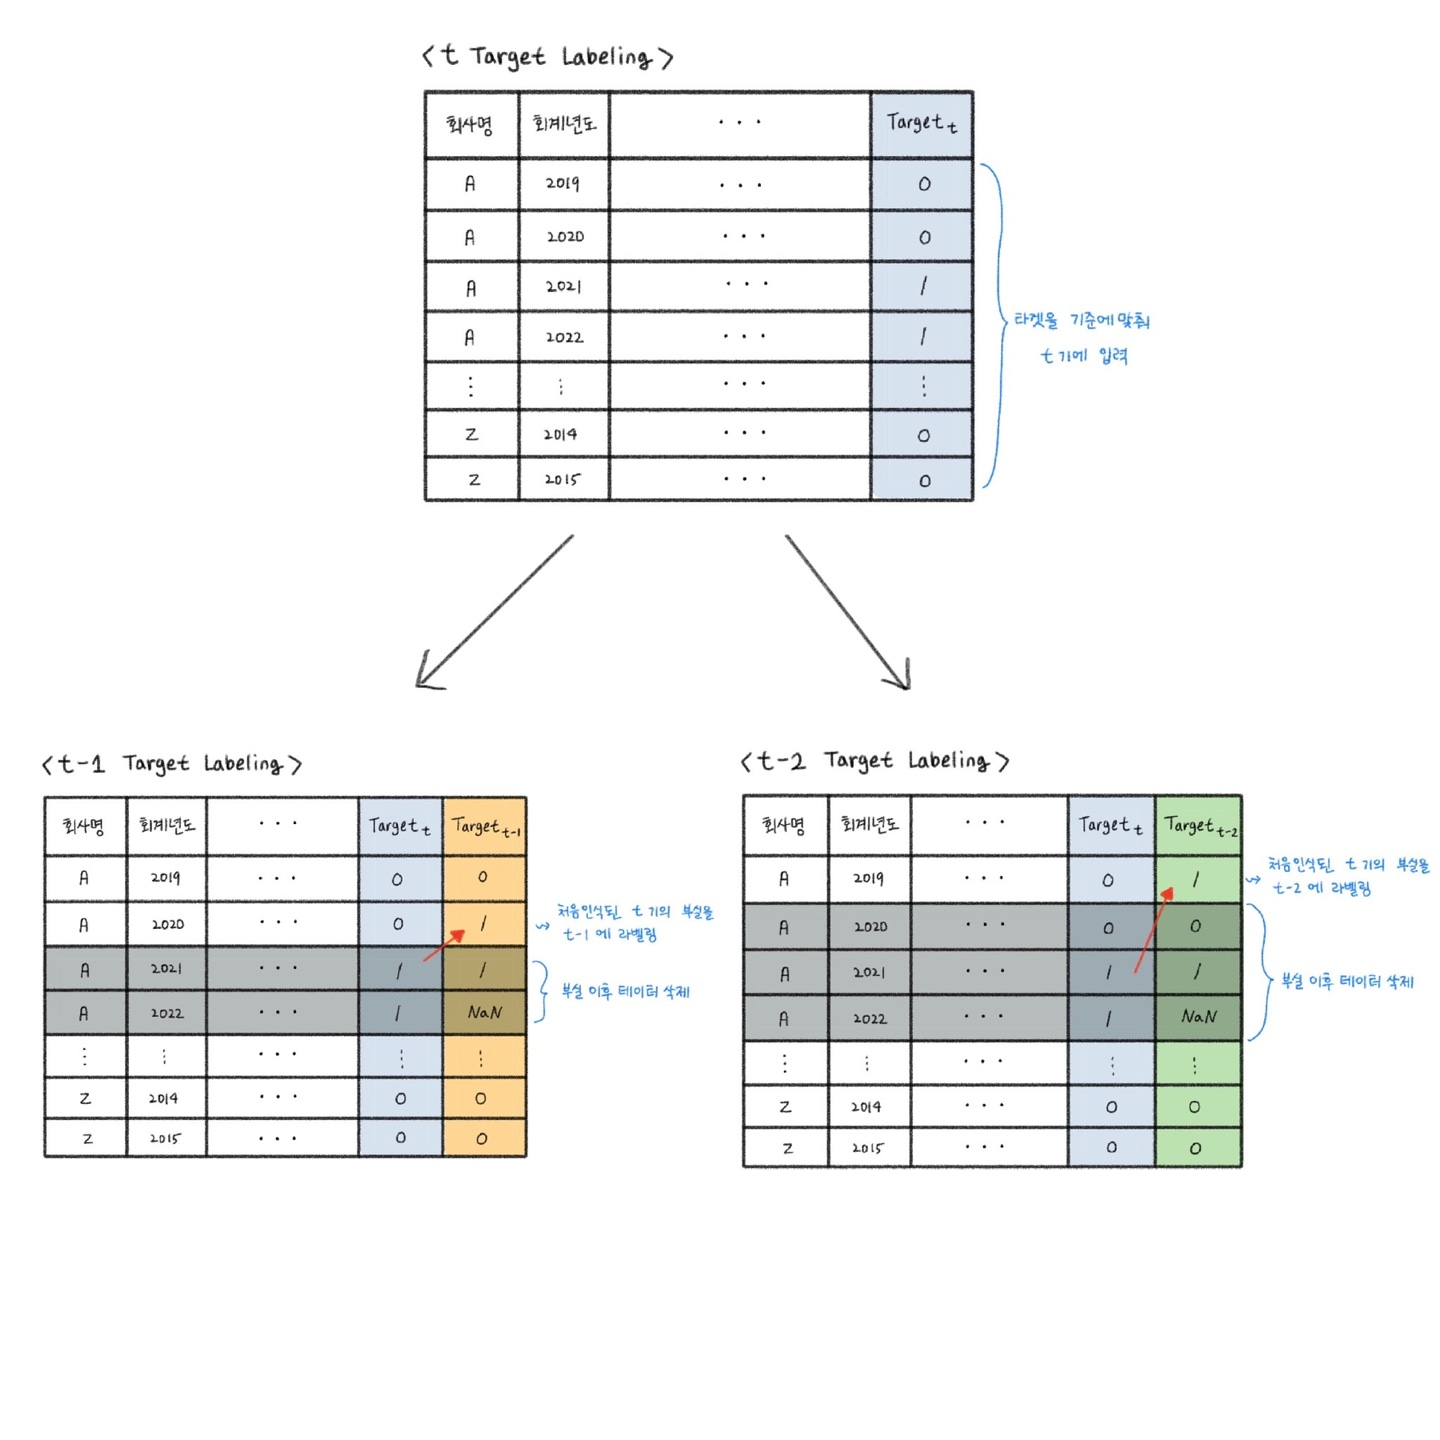


In [1]:
import pandas as pd
import numpy as np

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('./Dataset/상장raw2.csv',encoding='euc-kr')

In [3]:
df['PER'] = (df['PER(최고)(IFRS)'] + df['PER(최저)(IFRS)'])/2
df['PBR'] = (df['PBR(최고)(IFRS)'] + df['PBR(최저)(IFRS)'])/2

df.drop(columns=['PER(최고)(IFRS)','PER(최저)(IFRS)','PBR(최고)(IFRS)','PBR(최저)(IFRS)'],inplace=True)

In [4]:
df.shape

(24430, 56)

In [5]:
len(df['회사명'].unique())

2272

> 거래소코드 6자리 설정

- shape : (24430, 58) /  기업수 : 2272개

In [9]:
df['거래소코드'] = df['거래소코드'].astype(str).str.zfill(6)
# 외국계 기업 드랍
df = df[~df['거래소코드'].astype(str).str.startswith('9')]


---

## 투자회사, 부동산투자회사(리츠), spac및 페이퍼 컴퍼니 삭제!

In [10]:
df.drop(df[df['회사명'].str.contains('부동산투자회사')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('금융투자주식회사')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('선박투자회사')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('투자회사')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('스팩')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('spac')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('SPAC')].index, axis=0, inplace=True)
df.drop(df[df['회사명'].str.contains('투자')].index, axis=0, inplace=True)

In [11]:
df.isna().sum()

회사명                                      0
통계청 한국표준산업분류 10차(대분류)                    0
자본금(*)(IFRS연결)(천원)                     255
회사명.1                                    0
거래소코드                                    0
회계년도                                     0
통계청 한국표준산업분류 코드 10차(대분류)                 0
부채비율(IFRS연결)                           709
당좌비율(IFRS)                             710
유동비율(IFRS)                             710
이자보상배율(이자비용)(IFRS)                     710
영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)     255
이자비용(IFRS연결)(천원)                       255
차입금의존도(IFRS연결)                         709
자기자본구성비율(IFRS연결)                       709
당기순이익(손실)(IFRS연결)(천원)                  255
감가상각비(IFRS연결)(백만원)                     710
금융비용(IFRS연결)(백만원)                      710
단기차입금(*)(IFRS연결)(천원)                   255
유동성장기부채(*)(IFRS연결)(천원)                 255
장기차입금(*)(IFRS연결)(천원)                   255
EBITDA(IFRS)(백만원)                      710
매출액정상영업이익률(IFRS연결)                     709
자기자본순이익률(IF

---
# traget 레이블링   
    - 감사의견 코드(의견거절, 부적정, 한정중 감사범위 제한)
    - 자본잠식률>50
    - 회생절차 기업
    
1. 감사의견코드

In [12]:
df['감사의견코드']=df['감사의견코드'].map({
    'AG': 1,
    'DS':1,
    'DI':1,
    'DU':1,
    'QA':0,
    'QC':0,
    'QG':0,
    'QQ':0,
    'QS':1,
    'QU':0,
    'UQ':0,
    'ZZ':1
})

 2. 자본잠식  
    - 컬럼을 하나 만듬
    - 조건에 따라 레이블링
    

In [13]:
df['자본잠식률']=(df['자본금(*)(IFRS연결)(천원)'] - df['자본(*)(IFRS연결)(천원)'])/df['자본금(*)(IFRS연결)(천원)']

In [14]:
mask = (df['회사명'] == df['회사명']) & (df['자본잠식률'] >= 50)

df.loc[mask, '감사의견코드'] = 1.0

In [15]:
df[df['자본잠식률'].values >= 50]['감사의견코드'].value_counts()

감사의견코드
1.0    13
Name: count, dtype: int64

In [16]:
df.loc[mask, '감사의견코드'] = 1.0

In [17]:
mask.value_counts()

False    24277
True        13
Name: count, dtype: int64

In [18]:
df['감사의견코드'].value_counts()

감사의견코드
0.0    17338
1.0      112
Name: count, dtype: int64

3. 회생절차 기업 확인하기!

In [19]:
부도 = pd.read_csv('../외감기업/Dataset/회생신청/부도발생.csv', encoding='utf-8')
해산 = pd.read_csv('../외감기업/Dataset/회생신청/해산사유.csv', encoding='utf-8')
회생 = pd.read_csv('../외감기업/Dataset/회생신청/회생절차.csv', encoding='utf-8')

In [20]:
회생_list = 회생['회사명'].tolist()
회생_list

['CNT85',
 'ITX-AI',
 'ITX-AI',
 'ITX-AI',
 'MIT',
 'SBW생명과학',
 'STX중공업',
 '경남기업',
 '골드앤에스',
 '골프존데카',
 '구스앤홈',
 '극동건설',
 '금빛',
 '금오하이텍',
 '대한상선',
 '데코앤에프',
 '디아이디',
 '디아이디',
 '디에스앤엘',
 '디와이엘엔제이',
 '디피앤케이',
 '라이트론',
 '라이트론',
 '라임',
 '레드로버',
 '레드로버',
 '매직마이크로',
 '맥스로텍',
 '멜파스',
 '멜파스',
 '미래오토스',
 '바이오빌',
 '바이오빌',
 '베스파',
 '비디아이',
 '비엔디생활건강',
 '비츠로시스',
 '삼부토건',
 '삼환기업',
 '삼환기업',
 '상상인인더스트리',
 '세기리텍',
 '세미스트',
 '세미스트',
 '소리바다',
 '소리바다',
 '스틸플라워',
 '스포츠서울',
 '시너지이노베이션',
 '시스웍',
 '신텍',
 '신텍',
 '썬코어',
 '씨앤에스자산관리',
 '씨티네트웍스',
 '아리온',
 '아센디오',
 '아이엠텍',
 '아이톡시',
 '에스에이치엔엘',
 '에스에이치엔엘',
 '에스에이치엔엘',
 '에스엠화진',
 '에스제이케이',
 '에이원알폼',
 '에이치앤아이',
 '엔에스브이',
 '엔지스테크널러지',
 '엘아이에스',
 '엠피씨플러스',
 '우성아이비',
 '우양에이치씨',
 '우진엔지니어링',
 '웅진에너지',
 '월드파워텍',
 '웰킵스하이텍',
 '웹솔루스',
 '유디피',
 '이랩코리아',
 '이매진아시아',
 '이스타항공',
 '이앤코리아',
 '이엘케이',
 '이엠네트웍스',
 '이엠앤아이',
 '인켈',
 '제이웨이',
 '좋은사람들',
 '좋은사람들',
 '좋은사람들',
 '좋은사람들',
 '주노콜렉션',
 '지나인제약',
 '지나인제약',
 '지디',
 '지스마트글로벌',
 '지유온',
 '참존글로벌',
 '카페베네',
 '캐로스',
 '케스피온',
 '케이에스피',
 '케이조선'

In [21]:
회사_list = df['회사명'].tolist()
회사_list = [item.replace('(주)', '') for item in 회사_list]
unique_values = set(회사_list)

In [22]:
duplicates = set(unique_values) & set(회생_list)
duplicates

{'STX중공업',
 '골드앤에스',
 '디에스앤엘',
 '라이트론',
 '매직마이크로',
 '멜파스',
 '베스파',
 '비디아이',
 '비츠로시스',
 '삼부토건',
 '상상인인더스트리',
 '시너지이노베이션',
 '시스웍',
 '아센디오',
 '아이톡시',
 '엔지스테크널러지',
 '엘아이에스',
 '웰킵스하이텍',
 '이엠앤아이',
 '좋은사람들',
 '지나인제약',
 '케스피온',
 '케이에스피',
 '코데즈컴바인',
 '코센',
 '코스온',
 '테크엘',
 '하이소닉',
 '휴림네트웍스',
 '휴먼엔',
 '휴엠앤씨'}

In [23]:
df['회사명'] = df['회사명'].str.replace('(주)', '')

In [24]:
filtered_df = df[df['회사명'].isin(회생_list)]
filtered_df

,회사명,통계청 한국표준산업분류 10차(대분류),자본금(*)(IFRS연결)(천원),회사명.1,거래소코드,회계년도,통계청 한국표준산업분류 코드 10차(대분류),부채비율(IFRS연결),당좌비율(IFRS),유동비율(IFRS),...,재무활동으로 인한 현금흐름(*)(IFRS연결)(천원),자산(*)(IFRS연결)(천원),부채(*)(IFRS연결)(천원),자본(*)(IFRS연결)(천원),연구개발비(IFRS연결)(천원),* (정상)영업손익(보고서기재)(IFRS연결)(천원),감사의견코드,PER,PBR,자본잠식률
298,골드앤에스,정보통신업,25829040.0,(주)골드앤에스,035290,2011/12,58,108.04,95.73,109.25,...,-445968.0,46677146.0,24240316.0,22436829.0,0.0,1295340.0,0.0,24.02,3.120,0.131333
299,골드앤에스,정보통신업,35819682.0,(주)골드앤에스,035290,2012/12,58,103.59,127.38,141.03,...,9774762.0,51950606.0,26432789.0,25517817.0,0.0,-2330876.0,0.0,0.00,3.480,0.287603
300,골드앤에스,정보통신업,35819682.0,(주)골드앤에스,035290,2013/12,58,291.87,66.62,80.68,...,-1351541.0,51442505.0,38315150.0,13127355.0,0.0,-6493110.0,0.0,0.00,19.125,0.633516
301,골드앤에스,정보통신업,6077692.0,(주)골드앤에스,035290,2014/12,58,285.09,90.22,110.89,...,2956818.0,46528474.0,34445853.0,12082621.0,0.0,-3079598.0,0.0,0.00,9.390,-0.988028
302,골드앤에스,정보통신업,9852021.0,(주)골드앤에스,035290,2015/12,58,58.98,168.17,198.80,...,4121207.0,24102094.0,8941840.0,15160254.0,0.0,1143768.0,0.0,0.00,6.060,-0.538796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24368,휴림네트웍스,제조업,11912003.0,휴림네트웍스(주),192410,2018/12,26,151.20,132.30,154.04,...,8586010.0,112689957.0,67829912.0,44860045.0,0.0,-3598661.0,0.0,0.00,2.810,-2.765953
24369,휴림네트웍스,제조업,11912003.0,휴림네트웍스(주),192410,2019/12,26,115.50,136.60,152.49,...,-6727345.0,102970317.0,55189212.0,47781105.0,0.0,3645310.0,0.0,45.77,0.260,-3.011173
24370,휴림네트웍스,제조업,13451937.0,휴림네트웍스(주),192410,2020/12,26,109.84,204.99,210.16,...,-6642482.0,66434121.0,34774427.0,31659694.0,0.0,-11779313.0,0.0,0.00,3.115,-1.353542
24371,휴림네트웍스,제조업,14464950.0,휴림네트웍스(주),192410,2021/12,26,97.80,121.28,128.10,...,24973022.0,79086814.0,39104014.0,39982800.0,0.0,3253503.0,0.0,41.48,2.630,-1.764116


In [25]:
회생_df = 회생[회생['회사명'].isin(duplicates)]
회생_df = 회생_df[['회사명', '접수일']]

> 회계년도 일치시키기

In [26]:
회생_df['접수일'] = pd.to_datetime(회생_df['접수일']).dt.strftime('%Y')
df['회계년도'] = pd.to_datetime(df['회계년도']).dt.strftime('%Y')

In [27]:
회생_df.rename(columns={'접수일':'회계년도'}, inplace=True)

In [28]:
merged_df = df.merge(회생_df, on=['회사명', '회계년도'])

In [29]:
merged_df = merged_df[['거래소코드', '회계년도']]

In [30]:
merged_df2 = df.merge(merged_df, on=['거래소코드', '회계년도'], how='inner', suffixes=('', '_merged'))
merged_df2['감사의견코드'].value_counts()

감사의견코드
0.0    23
1.0     7
Name: count, dtype: int64

In [31]:
df.loc[df.index.isin(merged_df2.index), '감사의견코드'] = 1

- 23개의 회사가 0에서 1로 레이블링 변경

In [33]:
df['감사의견코드'].value_counts()

감사의견코드
0.0    17304
1.0      149
Name: count, dtype: int64

---

> 오름차순으로 정렬 회사명, 거래소 코드로

In [34]:
df.sort_values(by=['회사명','거래소코드'], ascending=True,inplace=True)

> 회사명이 한개인 기업들 삭제

In [35]:
len(df[df['거래소코드'].map(df['거래소코드'].value_counts()) == 1])

6

In [36]:
df=df[df['거래소코드'].map(df['거래소코드'].value_counts()) != 1]

In [37]:
df['감사의견코드'].value_counts()

감사의견코드
0.0    17302
1.0      149
Name: count, dtype: int64

---

> 추가변수 : Year 만들기

In [38]:
df['Year']= df['회계년도'].replace('/','').astype(str).str[:4].astype(int)

> 회사 이름이 같고, 년도 차이가 일년만 나는 데이터프레임 확인!

> 만약 2017년에 부실징후 포착 -> 2016년에 레이블링을 해야하는데 ,공시자료 누락으로 인해 전 년도 데이터가 없어서 년도가 불연속인 경우 고려

In [39]:
df[~(df['회사명'] == df['회사명'].shift(-1)) | (abs(df['Year']-df['Year'].shift(-1)) == 1)]['감사의견코드'].value_counts()

감사의견코드
0.0    17299
1.0      148
Name: count, dtype: int64

---

- 우리의 목표는 최초 부실을 찾는 것!

* 기업의 target : 0 이면 --> 그 기업 데이터 모두 유지
* 기업의 target : 1 이면 --> 그 기업 1 이전 데이터 유지 & 1 이후 데이터 삭제

In [40]:
import pandas as pd

# 거래소코드로 그룹화하여 처리하는 함수
def process_group(group):
    # 빈 그룹인 경우 그대로 반환
    if group.empty:
        return group
    
    # 거래소코드 그룹별로 처리
    if 1 in group['감사의견코드'].values:
        # 1이 처음으로 나오는 인덱스 찾기
        first_index = group.index[group['감사의견코드'] == 1][0]
        
        # 처음으로 1이 나오는 행의 아래 행들 삭제
        group = group.loc[:first_index]
    else:
        # 1이 없는 경우 그룹 그대로 유지
        pass
    
    return group



In [41]:
# '거래소코드'로 그룹화하여 함수를 적용하고 다시 합치기
processed_df = df.groupby('거래소코드').apply(process_group)

In [42]:
processed_df.shape

(24012, 58)

In [43]:
processed_df['감사의견코드'].value_counts()

감사의견코드
0.0    17118
1.0       88
Name: count, dtype: int64

In [44]:
processed_df['감사의견코드'].isna().sum()

6806

--- 

* 기업의 개수가 1개인 기업은 drop!
    - 전 시점의 타겟을 레이블링 할건데 기업의 개수가 1개라면-->레이블링 불가

In [593]:
# processed_df=processed_df[processed_df['거래소코드'].map(processed_df['거래소코드'].value_counts()) != 1]

In [45]:
processed_df.shape

(24012, 58)

In [46]:
processed_df['감사의견코드'].value_counts()

감사의견코드
0.0    17118
1.0       88
Name: count, dtype: int64

In [47]:
processed_df['감사의견코드'].isna().sum()

6806

In [48]:
processed_df.drop(columns=['회사명.1'], inplace=True)

---

## t-1시점 레이블링

#### 거래소 코드가 같은 회사라면, t-1감사의견코드라는 행에 다음년도 감사의견코드 대입

In [49]:
mask = processed_df['거래소코드'] == processed_df['거래소코드'].shift(-1)
processed_df['t-1감사의견코드'] = np.where(mask,processed_df['감사의견코드'].shift(-1), np.nan)

In [50]:
processed_df['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    15952
1.0       76
Name: count, dtype: int64

In [51]:
processed_df.reset_index(drop=True,inplace=True)

In [52]:
# 거래소 코드로 묶기
grouped = processed_df.groupby('거래소코드')

# 같은 거래소 코드의 t-1감사의견코드에 1.0이 존재한다면 1.0행만 남기고 나머지 행들 삭제
filtered_rows = []
for name, group in grouped:
    if 1.0 in group['t-1감사의견코드'].values:
        filtered_rows.append(group[group['t-1감사의견코드'] == 1.0])
    else:
        filtered_rows.append(group)

result_df = pd.concat(filtered_rows)
result_df

,회사명,통계청 한국표준산업분류 10차(대분류),자본금(*)(IFRS연결)(천원),거래소코드,회계년도,통계청 한국표준산업분류 코드 10차(대분류),부채비율(IFRS연결),당좌비율(IFRS),유동비율(IFRS),이자보상배율(이자비용)(IFRS),...,부채(*)(IFRS연결)(천원),자본(*)(IFRS연결)(천원),연구개발비(IFRS연결)(천원),* (정상)영업손익(보고서기재)(IFRS연결)(천원),감사의견코드,PER,PBR,자본잠식률,Year,t-1감사의견코드
0,동화약품,제조업,27931470.0,000020,2011,21,47.82,114.00,150.60,14.58,...,109807603.0,229623874.0,1078470.0,25621666.0,NaN,8.160,0.655,-7.220973,2011,NaN
1,동화약품,제조업,27931470.0,000020,2012,21,42.86,108.52,146.77,9.47,...,97290002.0,226994670.0,851304.0,10002904.0,NaN,115.665,0.685,-7.126843,2012,NaN
2,동화약품,제조업,27931470.0,000020,2013,21,39.14,117.65,159.13,5.37,...,88934413.0,227231127.0,1363463.0,2062220.0,NaN,161.965,0.760,-7.135309,2013,NaN
3,동화약품,제조업,27931470.0,000020,2014,21,36.28,133.74,174.92,33.65,...,83347317.0,229725782.0,11770852.0,7794263.0,NaN,31.030,0.695,-7.224622,2014,NaN
4,동화약품,제조업,27931470.0,000020,2015,21,37.84,157.43,195.25,35.21,...,87069288.0,230117742.0,13329278.0,4812974.0,NaN,43.950,1.110,-7.238655,2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24007,마녀공장,제조업,50000.0,439090,2020,20,27.22,378.78,474.44,293.29,...,5060027.0,18586073.0,0.0,6530194.0,NaN,0.000,0.000,-370.721460,2020,NaN
24008,마녀공장,제조업,50000.0,439090,2021,20,26.06,386.08,477.59,494.57,...,8534083.0,32753071.0,0.0,17707605.0,NaN,0.000,0.000,-654.061420,2021,0.0
24009,마녀공장,제조업,1431826.0,439090,2022,20,20.40,436.97,573.54,763.98,...,10637886.0,52150539.0,0.0,24494755.0,0.0,0.000,0.000,-35.422400,2022,NaN
24010,오픈놀,정보통신업,222570.0,440320,2021,58,NaN,NaN,NaN,NaN,...,14074212.0,3366296.0,567647.0,231900.0,NaN,NaN,NaN,-14.124662,2021,NaN


In [53]:
result_df['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    15555
1.0       76
Name: count, dtype: int64

In [54]:
result_df.dropna(subset='t-1감사의견코드',axis=0,inplace=True)

In [55]:
result_df['t-1감사의견코드'].isna().sum()

0

In [56]:
result_df.isna().sum()

회사명                                     0
통계청 한국표준산업분류 10차(대분류)                   0
자본금(*)(IFRS연결)(천원)                     75
거래소코드                                   0
회계년도                                    0
통계청 한국표준산업분류 코드 10차(대분류)                0
부채비율(IFRS연결)                          213
당좌비율(IFRS)                            214
유동비율(IFRS)                            214
이자보상배율(이자비용)(IFRS)                    214
영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)     75
이자비용(IFRS연결)(천원)                       75
차입금의존도(IFRS연결)                        213
자기자본구성비율(IFRS연결)                      213
당기순이익(손실)(IFRS연결)(천원)                  75
감가상각비(IFRS연결)(백만원)                    213
금융비용(IFRS연결)(백만원)                     213
단기차입금(*)(IFRS연결)(천원)                   75
유동성장기부채(*)(IFRS연결)(천원)                 75
장기차입금(*)(IFRS연결)(천원)                   75
EBITDA(IFRS)(백만원)                     214
매출액정상영업이익률(IFRS연결)                    213
자기자본순이익률(IFRS연결)                      213
총자본순이익률(IFRS연결)                   

In [57]:
result_df.drop('감사의견코드',axis=1,inplace=True)

In [58]:
result_df.columns

Index(['회사명', '통계청 한국표준산업분류 10차(대분류)', '자본금(*)(IFRS연결)(천원)', '거래소코드', '회계년도',
       '통계청 한국표준산업분류 코드 10차(대분류)', '부채비율(IFRS연결)', '당좌비율(IFRS)', '유동비율(IFRS)',
       '이자보상배율(이자비용)(IFRS)', '영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)',
       '이자비용(IFRS연결)(천원)', '차입금의존도(IFRS연결)', '자기자본구성비율(IFRS연결)',
       '당기순이익(손실)(IFRS연결)(천원)', '감가상각비(IFRS연결)(백만원)', '금융비용(IFRS연결)(백만원)',
       '단기차입금(*)(IFRS연결)(천원)', '유동성장기부채(*)(IFRS연결)(천원)',
       '장기차입금(*)(IFRS연결)(천원)', 'EBITDA(IFRS)(백만원)', '매출액정상영업이익률(IFRS연결)',
       '자기자본순이익률(IFRS연결)', '총자본순이익률(IFRS연결)', '매출액(수익)(*)(IFRS연결)(천원)',
       '총자본회전률(IFRS연결)', '자기자본회전률(IFRS연결)', '운전자본회전률(IFRS연결)',
       '순운전자본회전률(IFRS연결)', '재고자산회전률(IFRS연결)', '당좌자산회전률(IFRS연결)',
       '유동자산회전률(IFRS연결)', '매출액증가율(IFRS연결)', '총자본증가율(IFRS연결)',
       '자기자본증가율(IFRS연결)', '순이익증가율(IFRS연결)', '유형자산증가율(IFRS연결)',
       '유동자산증가율(IFRS연결)', '재고자산증가율(IFRS연결)', '정상영업이익증가율(IFRS연결)',
       '총자본투자효율(IFRS연결)', '부가가치율(IFRS연결)', '노동소득분배율(IFRS연결)', '자본분배율(IFRS연결)',
       '이윤분배율(IFRS연결)', '투자활동으로 인한 

In [59]:
result_df.columns=['회사명','산업분류','자본금(천원)','거래소코드', '회계년도', 
                   '산업분류코드','부채비율', '당좌비율', '유동비율',
                   '이자보상배율', 'OCF(천원)',
                   '이자비용(천원)','차입금의존도', '자기자본구성비율', 
                   '당기순이익(천원)','감가상각비(백만원)', '금융비용(백만원)',
                   '단기차입금(천원)','유동성장기부채(천원)',
                   '장기차입금(천원)','법인세비용차감전손익(백만원)', '매출액영업이익률', 
                   '자기자본순이익률', '총자본순이익률', '매출액(천원)', 
                   '총자본회전률', '자기자본회전률', '운전자본회전률', 
                   '순운전자본회전률','재고자산회전률', '당좌자산회전률',
                   '유동자산회전률', '매출액증가율', '총자본증가율',
                   '자기자본증가율','순이익증가율', '유형자산증가율',
                   '유동자산증가율', '재고자산증가율', '영업이익증가율',
                   '총자본투자효율','부가가치율', '노동소득분배율', '자본분배율',
                   '이윤분배율', 'ICF(천원)','FCF(천원)', '자산총계(천원)',
                   '부채총계(천원)', '자본총계(천원)','연구개발비(천원)',
                   '영업손익(천원)', 'Year','PER','PBR','자본잠식률','t-1감사의견코드',]

In [60]:
result_df['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    15555
1.0       76
Name: count, dtype: int64

In [610]:
# result_df.to_csv('t-1_raw_상장.csv',index=False,encoding='utf-8')

---
- t-2 시점

In [61]:
processed_df2=processed_df[~(((processed_df['거래소코드']) ==1) & (processed_df['거래소코드'].value_counts()) == 1)]

mask = processed_df2['거래소코드'] == processed_df2['거래소코드'].shift(-1)
processed_df2['t-2감사의견코드'] = np.where(mask,processed_df2['t-1감사의견코드'].shift(-1), np.nan)

In [62]:
processed_df2['t-2감사의견코드'].value_counts()

t-2감사의견코드
0.0    14684
1.0       75
Name: count, dtype: int64

In [63]:
processed_df2.reset_index(drop=True,inplace=True)

In [64]:
processed_df2[['거래소코드','회사명','회계년도','감사의견코드','t-2감사의견코드']].iloc[100:150,:]

,거래소코드,회사명,회계년도,감사의견코드,t-2감사의견코드
100,000150,두산,2015,0.0,0.0
101,000150,두산,2016,0.0,0.0
102,000150,두산,2017,0.0,0.0
103,000150,두산,2018,0.0,0.0
104,000150,두산,2019,0.0,0.0
105,000150,두산,2020,0.0,0.0
106,000150,두산,2021,0.0,NaN
107,000150,두산,2022,0.0,NaN
108,000180,성창기업지주,2011,0.0,0.0
109,000180,성창기업지주,2012,0.0,0.0


In [65]:
# 거래소 코드로 묶기
grouped = processed_df2.groupby('거래소코드')

# 같은 거래소 코드의 t-2감사의견코드에 1.0이 존재한다면 1.0행만 남기고 나머지 행들 삭제
filtered_rows = []
for name, group in grouped:
    if 1.0 in group['t-2감사의견코드'].values:
        filtered_rows.append(group[group['t-2감사의견코드'] == 1.0])
    else:
        filtered_rows.append(group)

result_df = pd.concat(filtered_rows)
result_df

,회사명,통계청 한국표준산업분류 10차(대분류),자본금(*)(IFRS연결)(천원),거래소코드,회계년도,통계청 한국표준산업분류 코드 10차(대분류),부채비율(IFRS연결),당좌비율(IFRS),유동비율(IFRS),이자보상배율(이자비용)(IFRS),...,자본(*)(IFRS연결)(천원),연구개발비(IFRS연결)(천원),* (정상)영업손익(보고서기재)(IFRS연결)(천원),감사의견코드,PER,PBR,자본잠식률,Year,t-1감사의견코드,t-2감사의견코드
0,동화약품,제조업,27931470.0,000020,2011,21,47.82,114.00,150.60,14.58,...,229623874.0,1078470.0,25621666.0,NaN,8.160,0.655,-7.220973,2011,NaN,NaN
1,동화약품,제조업,27931470.0,000020,2012,21,42.86,108.52,146.77,9.47,...,226994670.0,851304.0,10002904.0,NaN,115.665,0.685,-7.126843,2012,NaN,NaN
2,동화약품,제조업,27931470.0,000020,2013,21,39.14,117.65,159.13,5.37,...,227231127.0,1363463.0,2062220.0,NaN,161.965,0.760,-7.135309,2013,NaN,NaN
3,동화약품,제조업,27931470.0,000020,2014,21,36.28,133.74,174.92,33.65,...,229725782.0,11770852.0,7794263.0,NaN,31.030,0.695,-7.224622,2014,NaN,NaN
4,동화약품,제조업,27931470.0,000020,2015,21,37.84,157.43,195.25,35.21,...,230117742.0,13329278.0,4812974.0,NaN,43.950,1.110,-7.238655,2015,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24007,마녀공장,제조업,50000.0,439090,2020,20,27.22,378.78,474.44,293.29,...,18586073.0,0.0,6530194.0,NaN,0.000,0.000,-370.721460,2020,NaN,0.0
24008,마녀공장,제조업,50000.0,439090,2021,20,26.06,386.08,477.59,494.57,...,32753071.0,0.0,17707605.0,NaN,0.000,0.000,-654.061420,2021,0.0,NaN
24009,마녀공장,제조업,1431826.0,439090,2022,20,20.40,436.97,573.54,763.98,...,52150539.0,0.0,24494755.0,0.0,0.000,0.000,-35.422400,2022,NaN,NaN
24010,오픈놀,정보통신업,222570.0,440320,2021,58,NaN,NaN,NaN,NaN,...,3366296.0,567647.0,231900.0,NaN,NaN,NaN,-14.124662,2021,NaN,NaN


In [66]:
result_df['t-2감사의견코드'].value_counts()

t-2감사의견코드
0.0    14328
1.0       75
Name: count, dtype: int64

In [67]:
result_df.dropna(subset='t-2감사의견코드',axis=0,inplace=True)

In [68]:
result_df['t-2감사의견코드'].isna().sum()

0

In [69]:
result_df.drop('감사의견코드',axis=1,inplace=True)

In [70]:
result_df.drop('t-1감사의견코드',axis=1,inplace=True)

In [71]:
result_df.columns

Index(['회사명', '통계청 한국표준산업분류 10차(대분류)', '자본금(*)(IFRS연결)(천원)', '거래소코드', '회계년도',
       '통계청 한국표준산업분류 코드 10차(대분류)', '부채비율(IFRS연결)', '당좌비율(IFRS)', '유동비율(IFRS)',
       '이자보상배율(이자비용)(IFRS)', '영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)',
       '이자비용(IFRS연결)(천원)', '차입금의존도(IFRS연결)', '자기자본구성비율(IFRS연결)',
       '당기순이익(손실)(IFRS연결)(천원)', '감가상각비(IFRS연결)(백만원)', '금융비용(IFRS연결)(백만원)',
       '단기차입금(*)(IFRS연결)(천원)', '유동성장기부채(*)(IFRS연결)(천원)',
       '장기차입금(*)(IFRS연결)(천원)', 'EBITDA(IFRS)(백만원)', '매출액정상영업이익률(IFRS연결)',
       '자기자본순이익률(IFRS연결)', '총자본순이익률(IFRS연결)', '매출액(수익)(*)(IFRS연결)(천원)',
       '총자본회전률(IFRS연결)', '자기자본회전률(IFRS연결)', '운전자본회전률(IFRS연결)',
       '순운전자본회전률(IFRS연결)', '재고자산회전률(IFRS연결)', '당좌자산회전률(IFRS연결)',
       '유동자산회전률(IFRS연결)', '매출액증가율(IFRS연결)', '총자본증가율(IFRS연결)',
       '자기자본증가율(IFRS연결)', '순이익증가율(IFRS연결)', '유형자산증가율(IFRS연결)',
       '유동자산증가율(IFRS연결)', '재고자산증가율(IFRS연결)', '정상영업이익증가율(IFRS연결)',
       '총자본투자효율(IFRS연결)', '부가가치율(IFRS연결)', '노동소득분배율(IFRS연결)', '자본분배율(IFRS연결)',
       '이윤분배율(IFRS연결)', '투자활동으로 인한 

In [72]:
result_df.columns=['회사명','산업분류','자본금(천원)','거래소코드', '회계년도', 
                   '산업분류코드','부채비율', '당좌비율', '유동비율',
                   '이자보상배율', 'OCF(천원)',
                   '이자비용(천원)','차입금의존도', '자기자본구성비율', 
                   '당기순이익(천원)','감가상각비(백만원)', '금융비용(백만원)',
                   '단기차입금(천원)','유동성장기부채(천원)',
                   '장기차입금(천원)','법인세비용차감전손익(백만원)', '매출액영업이익률', 
                   '자기자본순이익률', '총자본순이익률', '매출액(천원)', 
                   '총자본회전률', '자기자본회전률', '운전자본회전률', 
                   '순운전자본회전률','재고자산회전률', '당좌자산회전률',
                   '유동자산회전률', '매출액증가율', '총자본증가율',
                   '자기자본증가율','순이익증가율', '유형자산증가율',
                   '유동자산증가율', '재고자산증가율', '영업이익증가율',
                   '총자본투자효율','부가가치율', '노동소득분배율', '자본분배율',
                   '이윤분배율', 'ICF(천원)','FCF(천원)', '자산총계(천원)',
                   '부채총계(천원)', '자본총계(천원)','연구개발비(천원)',
                   '영업손익(천원)','PER','PBR','자본잠식률', 'Year', 't-2감사의견코드']

In [73]:
result_df['t-2감사의견코드'].value_counts()

t-2감사의견코드
0.0    14328
1.0       75
Name: count, dtype: int64

In [624]:
# result_df.to_csv('t-2_raw_상장.csv',index=False,encoding='utf-8')

In [ ]:
# processed_df.to_csv('t-2_raw_외감.csv',index=False,encoding='euc-kr')